## Demonstrate pure-steam runaway OLR behaviour

AGNI is designed to be used as an executable program, but this notebook applies it as a package for the purposes of demonstrating the canonical OLR-$T_s$ curve.   
In this sense, Julia will be familiar to Python users.   

### Import things
If `RAD_DIR` is unset, this assumes that SOCRATES is installed at `AGNI/socrates/`. Modify this as required.

In [1]:
# Set directory
ROOT_DIR = abspath(joinpath(pwd(),"../"))
if !haskey(ENV, "RAD_DIR")
    ENV["RAD_DIR"] = joinpath(ROOT_DIR,"socrates")
end

In [2]:
# Import system packages
using Printf
using DelimitedFiles
using Plots
using LaTeXStrings
using Pkg

In [3]:
# Import AGNI
Pkg.activate(ROOT_DIR)
using AGNI

# Disable logging from AGNI module
AGNI.setup_logging("",0)

  Activating project at `~/Projects/AGNI`


### Define atmosphere parameters

In [4]:
# Configuration options
instellation    = 1000.0  # Solar flux [W m-2]
gravity         = 9.81
radius          = 6.0e6
nlev_centre     = 100
p_surf          = 270.0     # bar
p_top           = 1e-7      # bar
mole_fractions  = Dict([("H2O", 1.0-1e-9),("N2",1e-9)])
save_frames     = false

spectral_file = joinpath(ROOT_DIR,"res","spectral_files","Oak","318","Oak.sf")
star_file     = joinpath(ROOT_DIR,"res","stellar_spectra","sun.txt")
output_dir    = joinpath(ROOT_DIR,"out") * "/"

"/home2/p321409/Projects/AGNI/out/"

In [5]:
# Create output directory
rm(output_dir,force=true,recursive=true)
mkdir(output_dir);

### Initialise the atmosphere

In [6]:
# Setup atmosphere
atmos = atmosphere.Atmos_t()
atmosphere.setup!(atmos, ROOT_DIR, output_dir,
                        spectral_file,
                        instellation, 1.0, 0.0, 48.19,
                        1700.0,
                        gravity, radius,
                        nlev_centre, p_surf, p_top,
                        mole_fractions, "",
                        flag_gcontinuum=true,
                        thermo_functions=false,
                        real_gas=false,
                        condensates = ["H2O"]
                        )
atmosphere.allocate!(atmos, star_file; check_safe_gas=false)

true

### Run the model across an interval of $T_s$ values   
The fluxes are calculated at each pressure and wavelength point, but we only need the OLR.

In [7]:
# Setup arrays for OLR curve
tsurf_arr = collect(Float64, range(start=200,stop=2400,step=50))
run_len = length(tsurf_arr)
olr_arr = zeros(Float64, run_len);

In [8]:
# Loop over Tsurf, calculating OLR for each
for i in 1:run_len

    # Set to required Tsurf
    atmos.tmp_surf = tsurf_arr[i]
    fill!(atmos.tmpl, atmos.tmp_surf)
    fill!(atmos.tmp, atmos.tmp_surf)

    # Reset pressure array
    atmos.p_oboa = p_surf * 1e5  # reset surface pressure [bar -> Pa]
    atmos.p_boa  = atmos.p_oboa
    atmosphere.generate_pgrid!(atmos)

    # Reset mixing ratios
    chemistry.restore_composition!(atmos)

    # Calculate temperature profile
    chemistry._sat_surf!(atmos)
    setpt.dry_adiabat!(atmos)
    setpt.saturation!(atmos, "H2O")

    # Calculate layer properties
    atmosphere.calc_layer_props!(atmos)

    # Calculate LW fluxes
    energy.radtrans!(atmos, true)

    tsurf = round(Int,atmos.tmpl[end])

    olr = atmos.flux_u_lw[1]
    @printf("%2d: Tsurf = %5.1f K  ,  OLR = %5.1f W m-2 \n",i,tsurf,olr)
    olr_arr[i] = olr

    if save_frames
        save.write_ncdf(atmos, joinpath(output_dir, "atm_$tsurf.nc"))
        plotting.plot_pt(atmos, joinpath(output_dir, "atm_$tsurf.png"))
    end

end

 1: Tsurf = 200.0 K  ,  OLR =  90.7 W m-2 
 2: Tsurf = 250.0 K  ,  OLR = 216.8 W m-2 
 3: Tsurf = 300.0 K  ,  OLR = 276.4 W m-2 
 4: Tsurf = 350.0 K  ,  OLR = 276.5 W m-2 
 5: Tsurf = 400.0 K  ,  OLR = 276.1 W m-2 
 6: Tsurf = 450.0 K  ,  OLR = 275.8 W m-2 
 7: Tsurf = 500.0 K  ,  OLR = 275.5 W m-2 
 8: Tsurf = 550.0 K  ,  OLR = 275.3 W m-2 
 9: Tsurf = 600.0 K  ,  OLR = 275.1 W m-2 
10: Tsurf = 650.0 K  ,  OLR = 274.8 W m-2 
11: Tsurf = 700.0 K  ,  OLR = 274.8 W m-2 
12: Tsurf = 750.0 K  ,  OLR = 274.8 W m-2 
13: Tsurf = 800.0 K  ,  OLR = 274.8 W m-2 
14: Tsurf = 850.0 K  ,  OLR = 274.8 W m-2 
15: Tsurf = 900.0 K  ,  OLR = 274.7 W m-2 
16: Tsurf = 950.0 K  ,  OLR = 274.7 W m-2 
17: Tsurf = 1000.0 K  ,  OLR = 274.6 W m-2 
18: Tsurf = 1050.0 K  ,  OLR = 274.6 W m-2 
19: Tsurf = 1100.0 K  ,  OLR = 274.5 W m-2 
20: Tsurf = 1150.0 K  ,  OLR = 274.5 W m-2 
21: Tsurf = 1200.0 K  ,  OLR = 274.4 W m-2 
22: Tsurf = 1250.0 K  ,  OLR = 274.3 W m-2 
23: Tsurf = 1300.0 K  ,  OLR = 274.3 W m-2 
24: 

### Save these data to a CSV

In [9]:
# Write data
@printf("Writing data\n")
open(joinpath(output_dir,"OLR_vs_Tsurf.csv"),"w") do hdl
    writedlm(hdl, [tsurf_arr olr_arr], ", ")
end

Writing data


### Make plot using the Plots.jl library

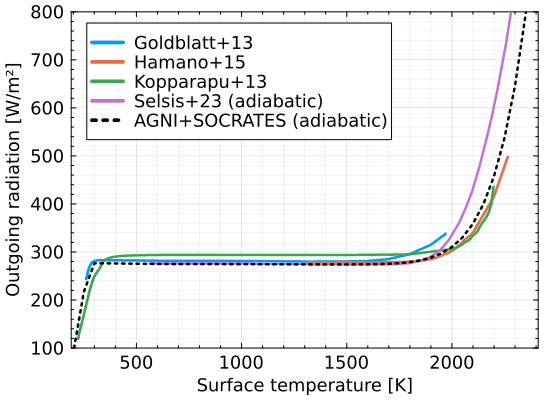

Making plot


In [18]:
# Make plot
@printf("Making plot\n")
fs=12
plt = plot(framestyle=:box,
            xlims=(tsurf_arr[1]-10,tsurf_arr[end]+10),
            ylims=(100,800),
            size=(550,400),
            guidefontsize=fs, tickfontsize=fs, legendfontsize=fs,
            minorgrid=true,
            leg=:topleft)

lw=2.5

litdata = readdlm(joinpath(ROOT_DIR,"res/literature_data/runaway/Goldblatt13_data.txt"), ',', Float64; header=false, skipstart=2)
plot!(plt, litdata[:,1] , litdata[:,2], label=" Goldblatt+13", lw=lw)

litdata = readdlm(joinpath(ROOT_DIR,"res/literature_data/runaway/Hamano15_data.txt"), ',', Float64; header=false, skipstart=2)
plot!(plt, litdata[:,1] , litdata[:,2], label=" Hamano+15", lw=lw)

litdata = readdlm(joinpath(ROOT_DIR,"res/literature_data/runaway/Kopparapu13_data.txt"), ',', Float64; header=false, skipstart=2)
plot!(plt, litdata[:,1] , litdata[:,2], label=" Kopparapu+13", lw=lw)

litdata = readdlm(joinpath(ROOT_DIR,"res/literature_data/runaway/Selsis23_convective.txt"), ',', Float64; header=false, skipstart=2)
plot!(plt, litdata[:,1] , litdata[:,2], label=" Selsis+23 (adiabatic)", lw=lw)

plot!(tsurf_arr,olr_arr,label=" AGNI+SOCRATES (adiabatic)", lw=lw, linecolor=:black, linestyle=:dot)

xlabel!(plt, "Surface temperature [K]")
ylabel!(plt, "Outgoing radiation [W/m²]")

# Show in notebook
display(plt)

# Save to output
savefig(plt, joinpath(output_dir,"runaway_olr.pdf"));

We can see that AGNI (and SOCRATES, specifically) is reproducing the literature results.